# Capstone Project Sandboo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

import drawSvg as draw

/Users/ssrosa/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/Users/ssrosa/anaconda3/lib/python3.7/site-packages/drawSvg/raster.py:11: RuntimeWarning: CairoSVG will need to be installed to rasterize images: Install with `pip3 install cairosvg`
  warnings.warn(msg, RuntimeWarning)


In [2]:
class Council(object):
    '''
    Haven't decided yet what zoning attribute should be. For now the zone() method
    does not pull directly from the zoning attribute but rather requires a separate
    zoned_as parameter be passed.
    '''
    def __init__(self, zoning):
        self.zoning = zoning
    def zone(self, land, to_zone_as):
        land.zoned_as.append(to_zone_as)

class District(object):
    def __init__(self):
        self.zoned_as = []
        self.blocks = [[]]
    def update(self):
        #Append last time step's blocks
        self.zoned_as.append(self.zoned_as[-1])
        self.blocks.append([b for b in self.blocks[-1]])        
        
class Block(object):
    def __init__(self, size):
        self.size = size
        self.district = None
        self.zoned_as = []
        #Coords where block is. Just for viz
        self.loc = []
        self.residences = [[]]
    def update(self):
        #Append last time step's residences
        self.zoned_as.append(self.zoned_as[-1])
        self.residences.append([r for r in self.residences[-1]])

class Developer(object):
    def __init__(self):
        self.residences_built = [[]]
        #100sqft - about a 9X12 room
        #Hard coded for now
        self.MIN_RES_SIZE = 425
    def build_on(self, block):
        #Remaining empty land on this block:
        avail_area = block.size - sum([residence.size for residence in block.residences[-1]])
        #If avail_area not large enough to put up a building
        if  avail_area < self.MIN_RES_SIZE:
            return
        #If avail area exceeds min residence size that this developer can build
        else:
            #Distribution of possible sizes for a new residence
            if avail_area > (block.size / 2):
                #Building cannot be bigger than half the block.
                #(Helps with viz.)
                max_res_size = (block.size / 2)
            else:
                #Otherwise building can be as big as the avail land.
                max_res_size = avail_area
            size_dist = np.arange(self.MIN_RES_SIZE, max_res_size + 1)
            #Initialize new residence object
            #Give residence a random size within the realm of possibility
            size = np.random.choice(size_dist)
            residence = Residence(block, size, block.zoned_as[-1])
            #Add residence to last list of residences built on the block
            block.residences[-1].append(residence)
            #Add residence to last list of residence built by this developer
            self.residences_built[-1].append(residence)
    def evict_all(self, residence):
        [u.occ[-1].move_out() for u in residence.units[-1] if u.occ[-1]]
    def demolish(self, residence):
        #Make all households move out
        self.evict_all(residence)
        #Remove this residence from the block's list. (Will remove it from all records moving forward.)
        residence.block.residences[-1].remove(residence)
        #Remove the block from this residence
        residence.block = False

class Residence(object):
    def __init__(self, block, size, zoned_as):
        
        #Building cannot be moved, resized, or rezoned.
        self.block = block
        self.size = size
        self.zoned_as = zoned_as
        #100sqft - about a 9X12 room
        #Hard coded for now
        self.min_unit_size = 100
        
        max_units = self.zoned_as 
        self.units = [[]]
        #Not clear at this point whether nested list will be necessary but am including it for now.
        max_units = zoned_as
        #Units can be larger than 100 sqft
        if size / max_units >= self.min_unit_size:
            self.unit_size = size / max_units
        #But cannot be smaller
        else:
            self.unit_size = self.min_unit_size
        avail_area = self.size
        while  avail_area >= self.unit_size:
            #Create a new unit object
            unit = Unit(self, self.unit_size)
            #Add unit object to last item of Residence's units list.
            self.units[-1].append(unit)
            avail_area -= self.unit_size

class Unit(object):
    def __init__(self, residence, size):
        self.residence = residence
        self.size = size
        #Value is a list. -1 is current value.
        self.value = [(size * price_sqft)]
        #Occupant is a list. -1 is current occupant.
        self.occ = [False]
    def update(self):
        self.value.append(self.value[-1])
        self.occ.append(self.occ[-1])

class Household(object):
    '''
    '''
    def __init__(self, has):
        #List of whether the household is homeless or not
        self.housed = [False]
        #Hold income constant for now but still write as a list
        self.has = [has]
    
    def update(self):
        self.housed.append(self.housed[-1])
        self.has.append(self.has[-1])
    
    def can_move_in(self, unit):
        #household needs a place to live
        #unit not already taken
        # household can afford unit 
        if (not self.housed[-1]) \
        and (not unit.occ[-1]) \
        and (unit.value[-1] <= self.has[-1]):        
            return True
        else: 
            return False
    def must_move_out(self):
        #Household has a place to live
        #buts its value has risen above
        #household's spending power
        #Other conditions can be added later
        if (self.housed[-1]) \
        and self.has[-1] < self.housed[-1].value[-1]:
            return True
        else:
            return False
        
    def move_in(self, unit):
        #Household becomes occupant of unit
        unit.occ[-1] = self
        #Houshold marks itself as housed
        self.housed[-1] = unit
        #print(f'Household {self.has[-1]} now lives in unit {unit.value[-1]}')
    
    def move_out(self):
        #Unit loses occupant
        self.housed[-1].occ[-1] = False
        #Household marks itself as unhoused
        self.housed[-1] = False

def create_councils(self, council_count, zoning):
            #Create a council to zone blocks
    councils = []
    for i in range(council_count):
        council = Council(zoning)
        councils.append(council)
    return councils
        
def create_blocks(self, land, block_size_avg, block_size_std):
    new_blocks = []
    #Create a distribution to simulate variety of block sizes
    #block_dist = np.random.normal(scale = block_size_std, loc = block_size_avg, size = block_count)
    #Create a distribution to simulate variety of zoning
    #Empty for now
    size = BLOCK_SIZE
    while land > 0:
        #size = np.round(np.random.choice(block_dist, replace = False), 0)
        #Create a new block only if the block size will fit on the available land left
        if size > land:
            #Need to break the loop here otherwise it keeps running until a random size is
            #drawn that fits the available remaining land. Could be tiny.
            break
        else:
            #Instantiate a block with a random size
            #HARD CODING block SIZE AS  100000
            block = Block(size)
            #Reduce available land area by the size of this block
            land -= size
            #Add this block to the list of blocks in the sim
            new_blocks.append(block)
    #Append this list to the list of blocks as the last item        
    return new_blocks

def create_districts(blocks):
    '''
    Map blocks onto districts evenly.
    '''
    blocks_to_assign = [b for b in blocks]
    districts = []
    for i in range(DISTRICTS_COUNT):
        district = District()
        districts.append(district)
    #While there are still blocks to assign
    while blocks_to_assign:
        #For each district
        for d in districts:
            #If the list hasn't run out of values while iterating
            if blocks_to_assign:
                #Give the first block to the district and remove it from the list of blocks
                blocks_to_assign[0].district = d
                d.blocks[-1].append(blocks_to_assign.pop(0))       
            else:
                break
    return districts
    
def create_developers(self, dev_count):
    '''
    Instantiate some number of developer objects.
    '''
    developers = []
    for i in range(dev_count):
        developer = Developer()
        developers.append(developer)
    #Return developers as a list to be stored
    return developers

def round_of_zoning(self, council, districts):
    '''
    Takes one council, not a list of councils.

    '''
    #FOR NOW HARD CODING THE ZONES HERE
    zones = [1, 1, 1, 1, 1, 2, 2, 4, 4, 16]
    
    #Zone each district
    for d, z in zip(districts, zones):
        council.zone(d, z)
        #Zone all the blocks the same way as their district
        for b in d.blocks[-1]:
            council.zone(b, d.zoned_as[-1])
                
def round_of_developing(self, developers, blocks):
    '''
    Iterate over list of developers and call each developer's develop method
    '''
    [developer.build_on(block) for block in blocks for developer in developers]

def create_households(self, pop_growth, has_avg, has_std):
    '''
    Create some number of households to come to the city.
    '''
    income_dist = np.random.normal(scale = has_std, loc = has_avg, size = pop_growth)
    new_households = [Household(i) for i in income_dist]
    #self.households[-1].extend(
    #Return the new households as a list
    return new_households

def round_of_moving_in(self):
    '''
    Must be called after time_step() has updated unit and household lists,
    and before round_of_moving_out.
    Prepare lists of units available and unhoused households, then call match()
    to iterate over units to place households in them.
    (What could be a very slow for loop is optimized by preparing shorter lists
    with only the relevant units and households.)
    '''
    print('Round of moving')
    print('#Prepare units and households for moving.')
    #Prepare units and households for moving.
    print('#Step 1: Get units available.')
    #Step 1: Get units available.
    ua = sorted([u for u in self.units[-1] if not u.occ[-1]], \
                        key = lambda u: u.value[-1], reverse = True)
    print(f'{len(ua)} units available')
    print('#Step 2: Get households seeking unit.')
    #Step 2: Get households seeking unit.
    hh = sorted([h for h in self.households[-1] if not h.housed[-1]], \
                        key = lambda h: h.has[-1], reverse = True)
    print(f'{len(hh)} households available')
    print(f'#Step 3: Exclude any units with value above the max spending power of {hh[0].has[-1]}')
    #Step 3: Exclude any units with value above the max spending power 
    #of the households. (Wouldn't be able to rent to anyone)
    ua = [u for u in ua if u.value[-1] <= hh[0].has[-1]]
    #If list is empty, meaning no units are affordable for the richest household
    if not ua:
        print('No units available.')
        return
    print(f'{len(ua)} units available')
    print(f'#Step 4: Exclude any households with spending power less than {ua[0].value[-1]}')
    #Step 4: Exclude any households with spending power less than 
    #the lowest unit value. (Wouldn't be able to find a place.)
    #Keep hh same length as or shorter than ua.
    #(No unit can take more than household so there cannot be more hh than ua.)
    hh = [h for i, h in enumerate(hh) if (h.has[-1] >= ua[-1].value[-1]) and \
                                                                    (i < len(ua))]
    #If list is empty, mmeaning no households can afford what's available
    #This should never happen under the above conditional, but leaving it in for now
    if not hh:
        print('No households looking for units.')
        return
    print(f'{len(hh)} households available')
    print('#Step 5: call the match function to move households into units.')
    #Step 5: call the match function to move households into units.
    hh_remaining = match(hh, ua)
    print(f'{len(hh) - len(hh_remaining)} households out of {len(hh)} found housing')
    #These two numbers should be equal
    #hh_moved_count = sum([1 if h.housed[-1] else 0 for h in hh])
    #ua_moved_into_count = sum([1 if u.occ[-1] else 0 for u in ua])

def match(hh_, ua):
    '''
    Helper function for round of moving. Does the work of matching 
    household to unit. Iterates over units, trying to match each 
    to the highest-value household in the list. If there's a match,
    the household gets popped and the loop moves on to next unit.
    If there's not a match, the loop just moves on to the next unit. 
    A household can take a unit that ncosts less than or equal to
    its spending power. Some rich households may wind up getting 
    cheap units. Units may go untaken; households may go unhoused.

    '''
    #New list to avoid popping the original
    hh = [h for h in hh_]
    #For each unit in list 
    for u in ua:
        #If there are no households left in the list, stop iterating
        if not hh:
            break
        else:
            #If highest-value household can take the unit
            if hh[0].can_move_in(u):
                #Household gets unit
                hh[0].move_in(u)
                #Household gets removed from list
                hh.pop(0)
            #Else: no lower-valued households can take this unit. 
            #It goes unoccupied. Move on to the next unit.
            #Simplest fastest way to iterate over all of them!
    return hh

def round_of_moving_out(self):
    '''
    Must be called after round_of_moving_in().
    A given household should only move_in and move_out once per time step.
    '''
    #Iterate over all households. If a household is housed but 
    #can no longer afford its unit, it moves out.
    test = [h.move_out() for h in self.households[-1] if h.housed[-1] and \
                        h.must_move_out()]
    
    #Should be zero if no hh move out
    print(len(test))                
                
def print_stats(self, time_step):
    print(f'Population at time step {time_step}: {len(self.households[-1])}')
    print(f'{len(self.blocks[-1])} blocks on {LAND} sqft of land')
    print(f'{len(self.developers[-1])} developers')
    #Get number of residences. FOr now there's no master list for some reason
    residences_count = len(self.residences[-1])
    units_count = len(self.units[-1])
    print(f'{residences_count} residences and {units_count} units')
    housing = [True if household.housed[-1] else False for household in self.households[-1]]
    housed_count = sum(housing)
    homeless_count = len(housing) - housed_count
    print(f'{housed_count} households have housing and {homeless_count} households are homeless.')
    
class Simulation(object):
    def __init__(self, 
                 #For creating blocks
                 land, block_count, block_size_avg, block_size_std, zoning,
                 #For bringing builders and rulers to the city
                 dev_count, council_count,
                 #For bringing people to the city
                 pop_growth, has_avg, has_std, 
                 #For running the sim over time
                 total_time_steps, inflation):
        #Number of years to run sim
        self.total_time_steps = total_time_steps
        #List of increments by which to increase population
        self.pop_growth = pop_growth
        #Held as constant for now
        self.has_avg = has_avg
        #Held as constant for now
        self.has_std = has_std
        #Held as constant for now
        self.inflation = inflation
        
        #STEP 0:
        #Create councils
        councils = self.create_councils(council_count, zoning)
        self.councils = [councils]
        
        #STEP 1: 
        #Fill up land area with blocks
        #Will return a list of blocks. Becomes sim.blocks[-1]
        blocks = self.create_blocks(land, block_size_avg, block_size_std)
        self.blocks = [blocks]
    
        #Map all blocks onto districts as evenly as possible. 
        #District count is hard coded as a constant
        #This is done randomly, not by a council, as neighborhoods
        #would coalesce organically in real life.
        districts = create_districts(self.blocks[-1])
        self.districts = [districts]
        #Council zones all the districts and blocks
        #For now its the first council in the list of councils
        self.round_of_zoning(councils[0], self.districts[-1])
       
        #STEP 2: Create developers to build residences
        developers = self.create_developers(dev_count)
        #Start a list of lists of developers to keep track
        self.developers = [developers]
        #Have developers build new residences
        self.round_of_developing(self.developers[-1], self.blocks[-1])
        
        #Start a list of lists of residences
        self.residences = [[r for b in self.blocks[-1] for r in b.residences[-1]]]
        #Start a list of lists of units
        self.units = [[u for r in self.residences[-1] for u in r.units[-1]]]
        
        #STEP 3: Create people to come to the city and move in
        
        #Pop the last value of population growth
        new_households = self.create_households(self.pop_growth.pop(), 
                               self.has_avg, 
                               self.has_std)
        #Start a list of lists of households to keep track
        self.households = [new_households]
        #STEP 4: Let each household try to move into a house
        self.round_of_moving_in()
        
        #STEP 5: Print initial statistics
        print('Simulation started.')
        self.print_stats(0)
        
def time_step(self, step):
    
    #Demolish any old residences
    #pass
    #Kill off any old households
    #pass
    print('\n')
    print(f'Updating object records for time step {step}')
    #Update lists of objects:
    print(f'1. Copy list of blocks from time step {step - 1}')
    self.blocks.append([b for b in self.blocks[-1]])
    print('2. Update each block\'s own records')
    [b.update() for b in self.blocks[-1]]
    print('3. Update each unit\'s own records')
    #Update each existing unit
    [u.update() for u in self.units[-1]]
    #Update each existing household
    print(f'4. Copy list of developers from time step {step - 1}')
    self.developers.append([d for d in self.developers[-1]])
   
    print(f'5. Copy list of households from time step {step - 1}: ({len(self.households[-1])})')
    #Copy list of households from previous time step
    self.households.append([h for h in self.households[-1]])
    print(f'6. Update each household\'s own records')
    [h.update() for h in self.households[-1]]
    
    #Inflation increases values or something
    
    #New developers
    #Leave out for now
    #Will need to extend [-1] spot of developer list with any new developers
    
    #New households move to town
    print(f'7.New households coming to town!')
    new_households = self.create_households(self.pop_growth.pop(), self.has_avg, self.has_std)
    print(f'{len(new_households)} households arrived')
    self.households[-1].extend(new_households)
    #test to make sure lists of households are updating correctly
    #print([len(h_list) for h_list in self.households])
    print('8. Developers are building new residences on vacant land')
    #Build new residences on available land
    self.round_of_developing(self.developers[-1], self.blocks[-1])
    #Manually append the list of all residences
    print('9. Updating master of list of residences to include new construction')
    self.residences.append([r for b in self.blocks[-1] for r in b.residences[-1]])
    #Need to manually add units to list for sim
    print('appending new units to master list')
    self.units.append([u for r in self.residences[-1] for u in r.units[-1]])
    #Have homeless try to move into new places
    print('people moving in')
    self.round_of_moving_in()
    
    #Have those priced out of their units move out
    #Shoudl always be a different group of people who move in/out within a year
    print('people moving out')
    self.round_of_moving_out()
    
def run(self):
    pass
    for _ in tqdm(range(self.total_time_steps)):
        # Print out the current time step 
        print(f"Time step {_}")
        self.time_step(_)
        self.print_stats(_)
    
class History(object):
    def __init__(self, simulation):
        '''
        #More info on 'negative indices':
        #Households have 'has' lists of different lengths depending when they entered the sim.
        #Negative index allows loop to get the relevant value from a has list for each year.
        #.e.g. Year -11, year 0 out of 10, gets the -11th, or the first, value from a has list.
        #Year -1, year 10 out of 10, gets the -1th, or last, value from a has list. &c.
        '''
        self.sim = simulation
        
        #BY YEAR:
        l_range = np.flip(np.negative(np.arange(len(sim.blocks))) - 1)
        #Available land area
        l_avail = [sum([(b.size - sum([r.size for r in b.residences[i]])) \
                     for b in sim.blocks[i]]) for i in l_range]
        
        #Number of residences
        r_count = [len(r_list) for r_list in sim.residences]
        #Average residence size
        r_size_mean = [(sum([r.size for r in r_list]) / len(r_list)) for r_list in sim.residences]
        
        
        #Number of units
        u_count = [len(u_list) for u_list in sim.units]
        #Average unit size
        u_size_mean = [(sum([u.size for u in u_list]) / len(u_list)) for u_list in sim.units]
        #Negative indices to call on lists of varying lengths
        u_range = np.flip(np.negative(np.arange(len(sim.units))) - 1)
        #u_range does not go into dataframe
        #Average unit value
        u_value_mean = [(sum([u.value[i] for u in sim.units[i]]) / len(sim.units[i])) for i in u_range]
        
        h_count = [len(h_list) for h_list in sim.households]
        #hh_range is negative indices by which to call items from has list in each household.
        
        hh_range = np.flip(np.negative(np.arange(len(sim.households))) - 1)
        #hh_range is not included in the dataframe
        #Only households who were housed at the end of each year
        h_housed = [sum([1 for h in sim.households[i] if h.housed[i]]) for i in hh_range]
        #Only households who were unhoused at the end of each year
        h_unhoused = [sum([1 for h in sim.households[i] if not h.housed[i]]) for i in hh_range]
        #Average income of household by year
        h_has_mean = [sum([h.has[i] for h in sim.households[i]])\
                             / len(sim.households[i]) for i in hh_range]
        #Average time household spent living in sim by year
        #(i.e. average 'age' of household by year)
        h_age_mean = [sum([len(h.has[:i]) for h in sim.households[i]]\
                                ) / len(sim.households[i]) for i in hh_range]
        
        data = np.array([l_avail,
                         r_count, r_size_mean,
                         u_count, u_size_mean, u_value_mean,
                         h_count, h_housed, h_unhoused, h_has_mean, h_age_mean
                        ]).T
        columns = ['empty_land',
                    'r_count', 'r_size_mean',
                   'u_count', 'u_size_mean', 'u_value_mean', 
                   'h_count', 'h_housed', 'h_unhoused', 'h_income_mean', 'h_age_mean']
        
        
        self.all_by_year = pd.DataFrame(data = data, columns = columns).rename_axis('Year')
        
def draw_residences(drawing, residences, x, y):
    #Hard coded with block 'height' of 5
    residences_sorted = sorted([r for r in residences], key = lambda r: r.size, reverse = True)
    base_y = y
    BLOCK_DEPTH = 5
    max_y = y + BLOCK_DEPTH
    colors = ['dimgray', 'gray', 'darkgray', 'silver', 'lightgray', 'gainsboro', 'whitesmoke', 
          'lightslategray', 'azure', 'oldlace', 'lightcyan', 'palegoldenrod']
    #How many of the 120 points in a 5x24 grid each building gets
    dots = [r.size // 425 for r in residences_sorted]
    #i.e. street frontage in "dots"
    widths = [dot // 5 if (dot // 5) > 0 else 1 for dot in dots]
    #i.e. how far across the depth of the block in "dots".
    #(Most buildings will have a depth of 5, the whole depth of the block.)
    depths = [5 if (dot // 5) > 0 else dot for dot in dots]
    previous_width = 0
    for w, d in zip (widths, depths):
        #If the depth of this building plus the previous would exceed the edge of the block
        if (y + d) > max_y:
            #Go back to y of 0, edge the bottom edge of the block
            y = base_y
            #Start to the right of the previous building, not in front of it
            x += previous_width
        drawing.append(draw.Rectangle(x,y,w,d, fill = np.random.choice(colors)))
        #Width of this building to use next
        previous_width = w
        #Depth of this buidlign to try to put next building in front of
        y += d

def draw_district(drawing, column_max, blocks):
#Test of blocks with buildings together

    block = draw.Lines((0), (0),
                      (0), (0 + 5),
                      (0 + 24), (0 + 5),
                      (0 + 24), (0),
                      fill = 'white',
                      close = True,
                      stroke = 'black',
                      stroke_width = '0.2',
                      id = 'block')
    x = 0
    y = 0
    column = 0
    column_max = column_max
    alley = True
    #Draw first block from which to copy the others
    #Second block will actually get drawn on top of this one
    drawing.append(block)
    #for b in sim.districts[-1][0].blocks[-1]:
    for b in blocks:
        #Reset for new row above previous
        if column > column_max:
            column = 0
            x = 0
            if alley:
                y += 6
                alley = False
            elif not alley:
                y += 7
                alley = True
        drawing.append(draw.Use('block', x, y))
        draw_residences(drawing, b.residences[-1], x, y)
        x += 26
        column += 1

In [8]:
#Attach all these functions to the Simulation object
Simulation.create_councils = create_councils
Simulation.create_blocks = create_blocks
Simulation.create_developers = create_developers
Simulation.create_households = create_households
Simulation.round_of_zoning = round_of_zoning
Simulation.round_of_developing = round_of_developing        
Simulation.round_of_moving_in = round_of_moving_in
Simulation.round_of_moving_out = round_of_moving_out
Simulation.print_stats = print_stats
Simulation.time_step = time_step
Simulation.run = run

#CITY SETTINGS
#Size of land area in sqft (for now)
LAND = 1000020000 #one trillion sqft in SF #1000000000
block_count = 10
DISTRICTS_COUNT = 10
BLOCK_SIZE = 51000
#Avg and std not used for now
block_size_avg = 10000 #50000
block_size_std = 150
zoning = [1]

#Starting developers
DEV_COUNT = 10
#Starting councils
COUNCIL_COUNT = 1

#Starting population
pop_growth = [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 100000, 100000]

has_avg = 1500
has_std = 500

#Time and money
price_sqft = 10
inflation = 0.02
years = 10

In [9]:
%%time
#CREATE SIM
sim = Simulation(land = LAND, 
                 block_count = block_count, 
                 block_size_avg = block_size_avg, 
                 block_size_std = block_size_std,
                 zoning = zoning,
                 dev_count = DEV_COUNT,
                 council_count = COUNCIL_COUNT,
                 pop_growth = pop_growth, 
                 has_avg = has_avg, 
                 has_std = has_std, 
                 total_time_steps = years,
                 inflation = inflation
                 )


Round of moving
#Prepare units and households for moving.
#Step 1: Get units available.
396646 units available
#Step 2: Get households seeking unit.
100000 households available
#Step 3: Exclude any units with value above the max spending power of 3653.0005816367275
115115 units available
#Step 4: Exclude any households with spending power less than 3652.5
84091 households available
#Step 5: call the match function to move households into units.
84020 households out of 84091 found housing
Simulation started.
Population at time step 0: 100000
19608 blocks on 1000020000 sqft of land
10 developers
128777 residences and 396646 units
84020 households have housing and 15980 households are homeless.
CPU times: user 5.97 s, sys: 109 ms, total: 6.08 s
Wall time: 6.11 s


#  Running a sim

In [10]:
%%time
sim.run()

Time step 0


Updating object records for time step 0
1. Copy list of blocks from time step -1
2. Update each block's own records
3. Update each unit's own records
4. Copy list of developers from time step -1
5. Copy list of households from time step -1: (100000)
6. Update each household's own records
7.New households coming to town!
100000 households arrived
8. Developers are building new residences on vacant land
9. Updating master of list of residences to include new construction
appending new units to master list
people moving in
Round of moving
#Prepare units and households for moving.
#Step 1: Get units available.
313894 units available
#Step 2: Get households seeking unit.
115980 households available
#Step 3: Exclude any units with value above the max spending power of 3706.624434031216
33241 units available
#Step 4: Exclude any households with spending power less than 3706.25
33241 households available
#Step 5: call the match function to move households into units.
7329 househo

24819 units available
#Step 4: Exclude any households with spending power less than 3735.0
260 households available
#Step 5: call the match function to move households into units.
260 households out of 260 found housing
people moving out
0
Population at time step 6: 260000
19608 blocks on 1000020000 sqft of land
10 developers
129304 residences and 397914 units
93278 households have housing and 166722 households are homeless.
Time step 7


Updating object records for time step 7
1. Copy list of blocks from time step 6
2. Update each block's own records
3. Update each unit's own records
4. Copy list of developers from time step 6
5. Copy list of households from time step 6: (260000)
6. Update each household's own records
7.New households coming to town!
10000 households arrived
8. Developers are building new residences on vacant land
9. Updating master of list of residences to include new construction
appending new units to master list
people moving in
Round of moving
#Prepare units and 

# Visualizing a district

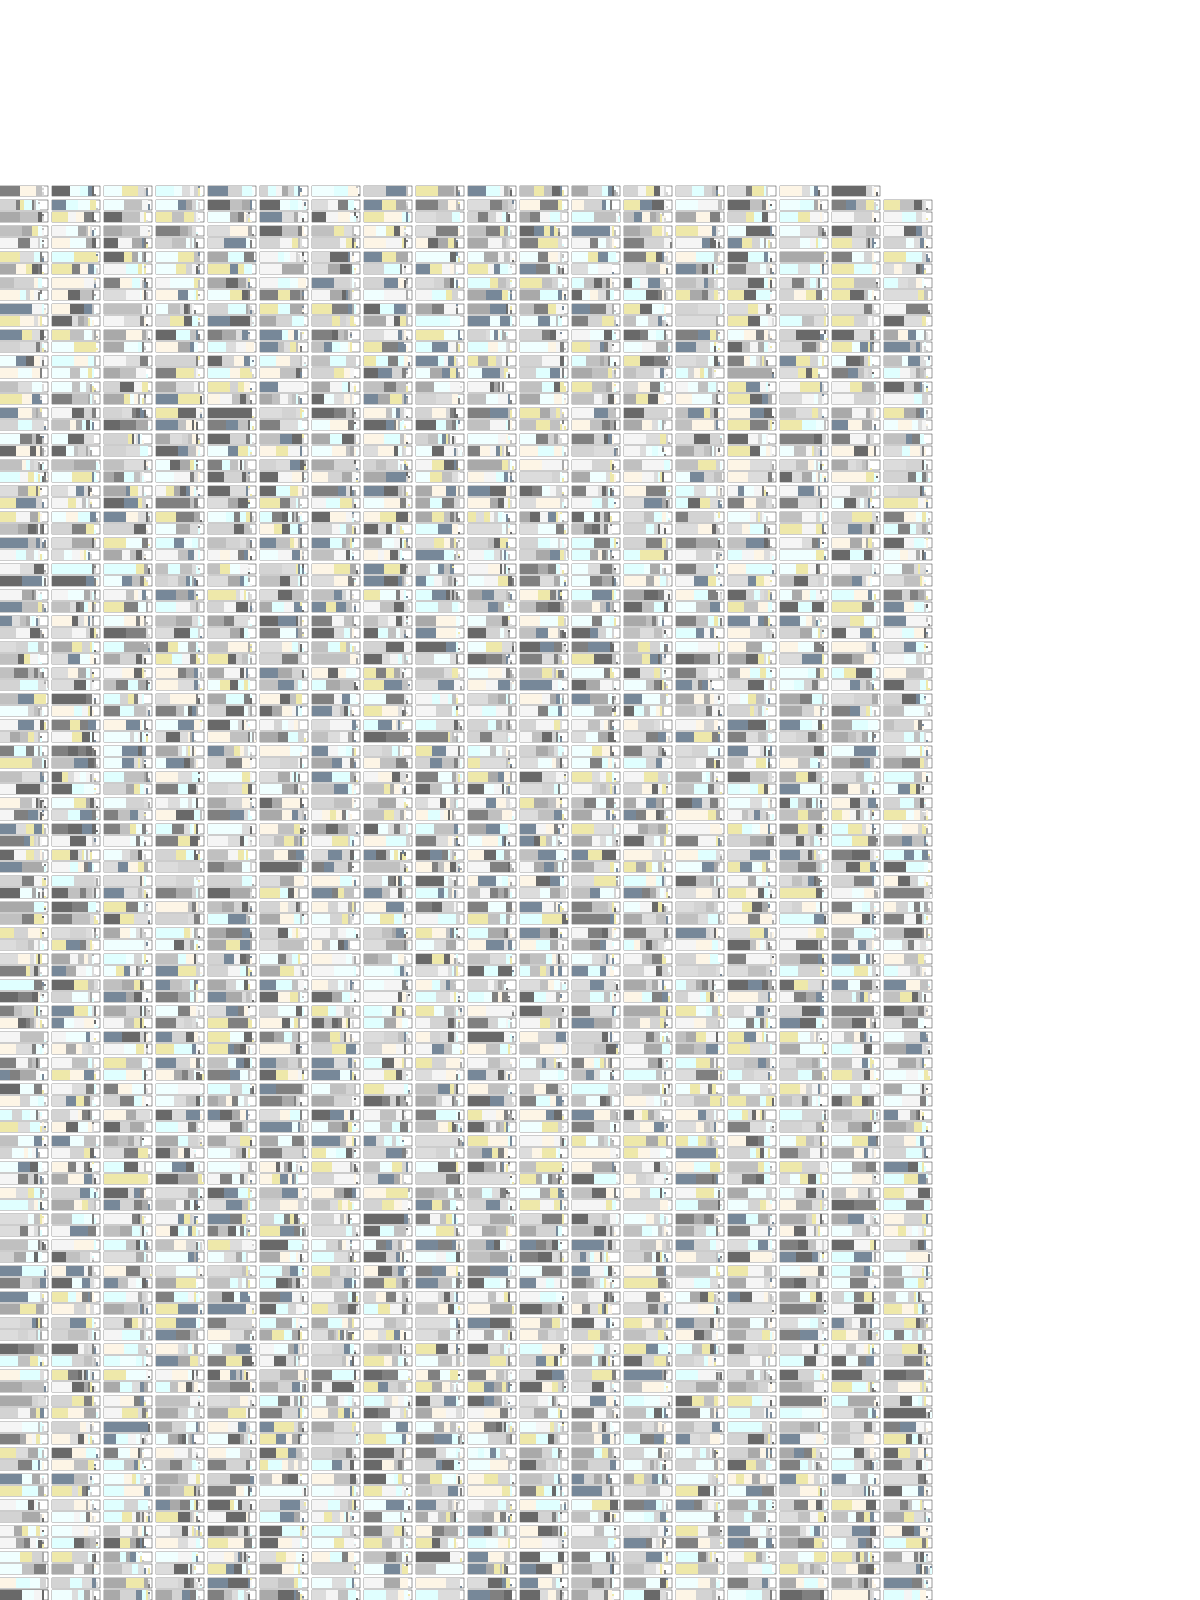

In [60]:
drawing = draw.Drawing(600, 800, origin = (0,0))
draw_district(drawing, 17, sim.districts[-1][0].blocks[-1])
drawing.setPixelScale(2) 

In [19]:
# residences = sorted([r for r in sim.blocks[-1][3].residences[-1]], key = lambda r: r.size, reverse = True)
# sizes = [r.size for r in residences]
# dots = [r.size // 425 for r in residences]
# widths = [d // 5 if (d // 5) > 0 else 1 for d in dots]
# heights = [5 if (d // 5) > 0 else d for d in dots]
# compare = pd.DataFrame(data = (np.array([sizes, dots, widths, heights]).T),
#                       columns = ['sizes', 'dots in grid', 'widths', 'heights'])

# Visualizing the history


In [12]:
%%time
hist = History(sim)


CPU times: user 3.67 s, sys: 34.8 ms, total: 3.71 s
Wall time: 3.73 s


In [13]:
hist.all_by_year


,empty_land,r_count,r_size_mean,u_count,u_size_mean,u_value_mean,h_count,h_housed,h_unhoused,h_income_mean,h_age_mean
Year,,,,,,,,,,,
0,3597068.0,128777.0,7737.491415,396646.0,2511.651916,25116.519163,100000.0,84020.0,15980.0,1498.080542,0.000000
1,3171851.0,129304.0,7709.244486,397914.0,2504.710231,25047.102314,200000.0,91349.0,108651.0,1499.306984,0.500000
2,3171851.0,129304.0,7709.244486,397914.0,2504.710231,25047.102314,210000.0,91775.0,118225.0,1499.846668,1.428571
3,3171851.0,129304.0,7709.244486,397914.0,2504.710231,25047.102314,220000.0,92147.0,127853.0,1499.980770,2.318182
4,3171851.0,129304.0,7709.244486,397914.0,2504.710231,25047.102314,230000.0,92486.0,137514.0,1500.349785,3.173913
5,3171851.0,129304.0,7709.244486,397914.0,2504.710231,25047.102314,240000.0,92763.0,147237.0,1499.957286,4.000000
6,3171851.0,129304.0,7709.244486,397914.0,2504.710231,25047.102314,250000.0,93018.0,156982.0,1499.887837,4.800000
7,3171851.0,129304.0,7709.244486,397914.0,2504.710231,25047.102314,260000.0,93278.0,166722.0,1499.970679,5.576923
8,3171851.0,129304.0,7709.244486,397914.0,2504.710231,25047.102314,270000.0,93516.0,176484.0,1500.285455,6.333333


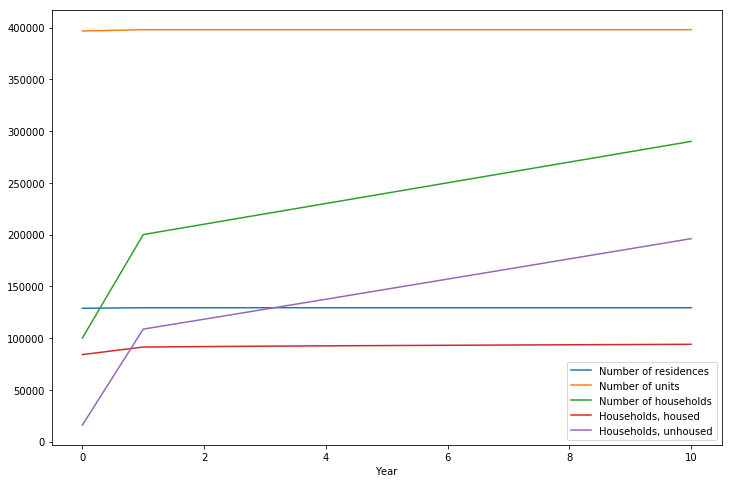

In [15]:
#Look at numbers of buildings and people by year
fig = plt.figure(figsize = (12, 8))
#plt.plot(hist.all_by_year['empty_land'], label = 'Land free for building')
plt.plot(hist.all_by_year['r_count'], label = 'Number of residences')
plt.plot(hist.all_by_year['u_count'], label = 'Number of units')
plt.plot(hist.all_by_year['h_count'], label = 'Number of households')
plt.plot(hist.all_by_year['h_housed'], label = 'Households, housed')
plt.plot(hist.all_by_year['h_unhoused'], label = 'Households, unhoused')
plt.xlabel('Year')
plt.legend()
plt.show()


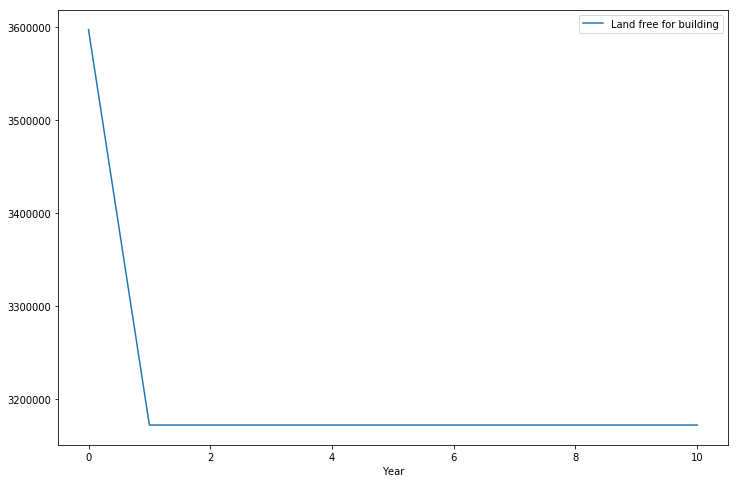

In [16]:
#Look at numbers of buildings and people by year
fig = plt.figure(figsize = (12, 8))
plt.plot(hist.all_by_year['empty_land'], label = 'Land free for building')
#plt.plot(hist.all_by_year['r_count'], label = 'Number of residences')

plt.xlabel('Year')
plt.legend()
plt.show()

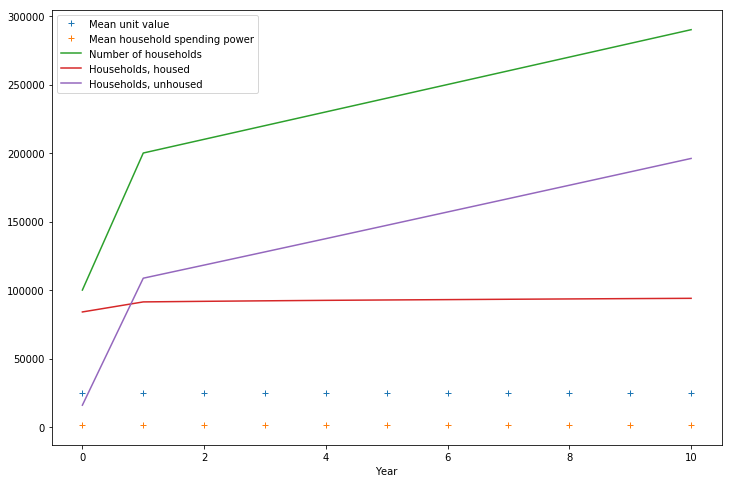

In [17]:
#Look at numbers of buildings and people by year
fig = plt.figure(figsize = (12, 8))
#plt.plot(hist.all_by_year['empty_land'], label = 'Land free for building')
plt.plot(hist.all_by_year['u_value_mean'], '+', label = 'Mean unit value')
plt.plot(hist.all_by_year['h_income_mean'], '+', label = 'Mean household spending power')
plt.plot(hist.all_by_year['h_count'], label = 'Number of households')
plt.plot(hist.all_by_year['h_housed'], label = 'Households, housed')
plt.plot(hist.all_by_year['h_unhoused'], label = 'Households, unhoused')

plt.xlabel('Year')
plt.legend()
plt.show()



# VARIOUS CHECKS FOR OBJECTS IN SIM

In [ ]:
#Zoning of each district
#[d.zoned_as[-1] for d in sim.districts[-1]]

#How many blocks per district
#[len(d.blocks[-1]) for d in sim.districts[-1]]

#CHECK FOR UNIT COUNTS IN DIFFERENT SIZED RESIDENCES
#how to write nested comp: smallest for biggest in biggest for second biggest in second biggest for third biggest in third biggest
#r_sizes = [r.size for d in sim.districts[-1] for b in d.blocks[-1] for r in b.residences[-1]]
#r_unit_count = [len(r.units[-1]) for d in sim.districts[-1] for b in d.blocks[-1] for r in b.residences[-1]]
#for size, unit_count in zip(r_sizes, r_unit_count):
#    print(size, unit_count)

In [ ]:
#For history object
#Test for lengths of these lists. They should all be equal length.
# print(len(residences_count))
# print(len(residence_size_avg))
# print(len(units_count))
# print(len(unit_size_avg))
# print(len(unit_value_avg))
# print(len(household_count))
# print(len(households_housed))
# print(len(households_unhoused))
# print(len(household_age_avg))
# print(len(household_has_avg))

In [ ]:
#This is the available area on one lot
#(sim.lots[0][0].size - sum([r.size for r in sim.lots[0][0].residences[0]]))

#Available area for all lots in one year
#[(l.size - sum([r.size for r in l.residences[0]])) \
#     for l in sim.lots[0]]

#Total area for one year vs avail area for one year
#total = sum([l.size  for l in sim.lots[0]])
#avail = sum([(l.size - sum([r.size for r in l.residences[0]])) \
     #for l in sim.lots[0]])

In [ ]:
#Check sizes of all lots
#sum([lot.size for lot in sim.lots[-1]])

In [ ]:
#Check size of each residence
#[residence.size for lot in sim.lots[-1] for residence in lot.residences[-1]]

In [ ]:
#Check size of each unit
#unit_sizes = [unit.value for lot in sim.lots[-1] for residence in lot.residences[-1] for unit in residence.units[-1]]

In [ ]:
#Check area of each residence that isn't carved into units
#[(residence.size - sum(unit.size for unit in residence.units[-1])) for lot in sim.lots[-1] for residence in lot.residences[-1]]

In [ ]:
#Check unbuilt land of each lot
#avail_area = [lot.size - sum([residence.size for residence in lot.residences[-1]]) for lot in sim.lots[-1]]
#Avail area on each lot should be less than min_size for building a new residence
#avail_area

In [ ]:
#Check how many residences on each lot
#[len(lot.residences[-1]) for lot in sim.lots[-1]]

In [ ]:
#Check how many units in each residence
#[len(residence.units[-1]) for lot in sim.lots[-1] for residence in lot.residences[-1]]

In [ ]:
#Check a single lot
#vars(sim.lots[-1][0])

In [ ]:
#Check a single residence on a lot
#vars(sim.lots[-1][0].residences[-1][0])

In [ ]:
#Check a single unit in a residence
#vars(sim.lots[-1][0].residences[-1][0].units[-1][0])

In [ ]:
#THIS IS GREAT CODE DON'T DELETE
#Check all unit values
#How to quadruple nest a list comprehension:
#smallest for biggest in biggest for second biggest in second biggest for third biggest in third biggest
unit_values = [unit.value[-1] for lot in sim.lots[-1] for residence in lot.residences[-1] for unit in residence.units[-1]]
#unit_values
#plt.hist(unit_values)

In [ ]:
#Get total number of units in all residences on all lots
len([unit.value[-1] for lot in sim.lots[-1] for residence in lot.residences[-1] for unit in residence.units[-1]])

In [ ]:
#Check incomes for all households
#incomes = [household.has[-1] for household in sim.households[-1]]
#plt.hist(incomes)

In [ ]:
#Check incomes for currently housed households
#incomes_currently_housed = [household.has[-1] for household in sim.households[-1] if household.housed[-1]]
#plt.hist(incomes_currently_housed)

In [ ]:
#Check housing history for all households
#housing_history = [household.housed for household in sim.households[-1]]
#housing_history

In [ ]:
# #Test for instantiation of lots, residences built by developers, units per residence
# for lot in sim.lots[-1]:
#     print('Lot size:', lot.size)
#     print('Number of buildings on lot:', len(lot.residences[-1]))
#     for residence in lot.residences[-1]:
#         print('Building size:', residence.size)
#         print('Building zoned as:', residence.zoned_as)
#         print('Units in building:', len(residence.units[-1]))
#         print('Sqft per unit:', residence.size / len(residence.units[-1]))
#         for unit in residence.units[-1]:
#             print('Unit size:', unit.size)
#             print('Unit initial value:', unit.value[0])
#             print('Unit current value:', unit.value[-1])
#             print('Household size:', unit.occ[-1].size)
#             print('Household spending power:', unit.occ[-1].size)
#     print('\n')